## Data Preparation

### Getting data from yfinance

In [93]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

import numpy as np
import os
import json

import pandas as pd
from sklearn.preprocessing import StandardScaler

from ta.momentum import RSIIndicator
from ta.trend import EMAIndicator, MACD
from ta.volatility import AverageTrueRange

import yfinance as yf


config = {
    "yfinance": {
        "symbol": "AAPL",
        "symbols":  [
            "AAPL", "MSFT", "GOOG", "AMZN", "META", "NVDA",
            "QCOM", "INTC", "AMD", "TSLA", "SONY", "SPY",
            "XLK", "CRM", "ORCL", "ADBE", "IBM", "TXN", "AMAT"
        ],
        "period": "10y",
        "interval": "1d",
    },
    "data": {
        "window_size": 20, # use information from past 20 days to predict
        "train_split_size": 0.70,
        "val_split_size": 0.15,
        "test_split_size": 0.15,
    }, 
    "plots": {
        "xticks_interval": 90,
        "color_actual": "#ff8000",
        "color_train": "#58F6AF",
        "color_val": "#7CC2FF",
        "color_test": "#FF6464",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#00529A",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 21,
        "num_lstm_layers": 3,
        "lstm_size": 64, # hidden state dimensionality
        "dropout": 0.3,
    },
    "training": {
        "device": "cuda" if torch.cuda.is_available() else "cpu",
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 1e-3,
        "weight_decay": 1e-2,
        "scheduler_step_size": 40,
    }
}

In [59]:
data_list = []

for symbol in config["yfinance"]["symbols"]:
    ticker = yf.Ticker(symbol)
    df = ticker.history(start="2015-01-01", auto_adjust=True, actions=False)
    df = df.add_prefix(f"{symbol}_")
    data_list.append(df)

combined_df = pd.concat(data_list, axis=1)
combined_df

,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Volume,MSFT_Open,MSFT_High,MSFT_Low,MSFT_Close,MSFT_Volume,...,TXN_Open,TXN_High,TXN_Low,TXN_Close,TXN_Volume,AMAT_Open,AMAT_High,AMAT_Low,AMAT_Close,AMAT_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02 00:00:00-05:00,24.718178,24.729274,23.821675,24.261051,212818400,39.847657,40.496696,39.745178,39.933056,27913900,...,39.970760,40.358826,39.560304,39.911057,4020100,21.833449,21.981976,21.492711,21.807238,6910200
2015-01-05 00:00:00-05:00,24.030267,24.110154,23.391177,23.577578,257142000,39.599988,39.907428,39.497509,39.565830,39673900,...,39.694626,39.918513,39.254321,39.291637,5599300,21.623773,21.754826,21.099560,21.108297,11419800
2015-01-06 00:00:00-05:00,23.641929,23.839426,23.218087,23.579796,263188400,39.608531,39.924510,38.891171,38.985111,36447900,...,39.470739,39.567757,38.597593,38.642368,5468400,21.082077,21.230604,20.295758,20.313232,19678300
2015-01-07 00:00:00-05:00,23.788382,24.010288,23.677428,23.910431,160423600,39.266919,39.676839,38.848461,39.480419,29114100,...,38.814014,39.455815,38.649834,39.336411,4577100,20.418076,20.566603,20.173443,20.505444,15710300
2015-01-08 00:00:00-05:00,24.238852,24.886819,24.121240,24.829123,237458000,39.924516,40.778516,39.898897,40.641876,29645200,...,39.649848,40.261798,39.560293,39.978210,6295200,20.697652,21.248075,20.680178,21.160706,16696900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-18 00:00:00-04:00,231.699997,233.119995,230.110001,230.889999,37476200,520.733964,521.961925,513.176381,516.251282,23760600,...,194.570007,195.520004,193.500000,194.330002,2763600,161.347567,164.079742,161.287741,163.062653,10125800
2025-08-19 00:00:00-04:00,231.279999,232.869995,229.350006,230.559998,39402600,514.154777,514.314488,507.715351,508.933350,21481000,...,194.669998,197.649994,193.789993,195.940002,5491100,163.770625,164.727873,161.028484,161.756393,8921500
2025-08-20 00:00:00-04:00,229.979996,230.470001,225.770004,226.009995,42263900,509.033198,510.161348,503.612117,504.890015,27723000,...,197.500000,201.229996,193.449997,200.770004,8107300,161.337596,161.507108,157.488627,160.500000,9323300


In [ ]:
combined_df["Date"] = pd.to_datetime(raw_data["Date"]).dt.strftime("%Y-%m-%d")
raw_data.to_json(json_file, orient="records", indent=4, date_format="iso")

In [453]:
with open(json_file, "r") as f:
    data = json.load(f)

df = pd.DataFrame(data)
df

,Date,Open,High,Low,Close,Volume
0,2000-08-23,60.078906,61.795448,59.860438,61.545769,4446755
1,2000-08-24,61.420887,62.638070,61.264841,62.325974,6263762
2,2000-08-25,62.076290,64.853962,62.045079,64.417023,8659834
3,2000-08-28,64.853974,66.508093,64.791553,65.665428,8929284
4,2000-08-29,65.665436,67.038669,65.415757,66.352051,6317840
...,...,...,...,...,...,...
6282,2025-08-18,239.570007,241.419998,239.119995,239.449997,3569600
6283,2025-08-19,240.000000,242.830002,239.490005,241.279999,3328300
6284,2025-08-20,242.110001,242.880005,240.339996,242.550003,3240100
6285,2025-08-21,242.210007,242.500000,238.649994,239.399994,2991900


### Compute technical indicators

In [63]:
all_indicators = []

for symbol in config["yfinance"]["symbols"]:
    df_ind = pd.DataFrame(index=combined_df.index)
    close = combined_df[f"{symbol}_Close"]
    
    df_ind[f"{symbol}_SMA_10"] = close.rolling(window=10).mean()
    df_ind[f"{symbol}_EMA_20"] = EMAIndicator(close, window=20).ema_indicator()
    
    macd = MACD(close)
    df_ind[f"{symbol}_MACD_diff"] = macd.macd_diff()
    
    df_ind[f"{symbol}_RSI_14"] = RSIIndicator(close, window=14).rsi()
    
    df_ind[f"{symbol}_ATR_14"] = AverageTrueRange(
        high=combined_df[f"{symbol}_High"], 
        low=combined_df[f"{symbol}_Low"], 
        close=combined_df[f"{symbol}_Close"],
        window=14).average_true_range()
    
    all_indicators.append(df_ind)

# Concatenate all indicator columns at once
indicators_df = pd.concat(all_indicators, axis=1)
combined_df = pd.concat([combined_df, indicators_df], axis=1)

combined_df = combined_df.iloc[35:].reset_index(drop=True)
combined_df

,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Volume,MSFT_Open,MSFT_High,MSFT_Low,MSFT_Close,MSFT_Volume,...,TXN_SMA_10,TXN_EMA_20,TXN_MACD_diff,TXN_RSI_14,TXN_ATR_14,AMAT_SMA_10,AMAT_EMA_20,AMAT_MACD_diff,AMAT_RSI_14,AMAT_ATR_14
0,28.988720,29.212433,28.838833,28.939503,153800400,40.504573,40.824869,39.993829,40.132336,27745500,...,41.787005,41.786271,-0.036597,36.692765,0.723741,17.829509,17.830753,0.076660,43.510962,0.372991
1,28.970820,29.013326,28.715787,28.780663,142507200,40.089064,40.270853,39.682199,39.941898,25438100,...,41.657803,41.677252,-0.084636,35.477063,0.708743,17.829509,17.824588,0.066083,45.843899,0.365242
2,28.836603,28.905957,28.373519,28.590521,210699200,40.080401,40.192939,39.535030,39.586971,22121600,...,41.465136,41.508817,-0.155455,30.010762,0.716405,17.805704,17.795500,0.041817,40.271459,0.366234
3,28.344431,28.653156,28.102822,28.505505,224301600,39.612944,39.768764,39.353244,39.517723,24406100,...,41.341225,41.363619,-0.184892,31.187984,0.711106,17.798650,17.772540,0.028153,41.367802,0.358968
4,28.617353,28.935025,28.601693,28.832119,156349200,39.638927,40.539222,39.552358,40.348774,28417400,...,41.206735,41.323636,-0.130012,44.056568,0.739647,17.772199,17.762683,0.026850,44.907572,0.347812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2566,231.699997,233.119995,230.110001,230.889999,37476200,520.733964,521.961925,513.176381,516.251282,23760600,...,189.702002,192.410741,1.365770,51.432508,4.722031,179.655096,181.208795,-2.267237,32.124853,6.134019
2567,231.279999,232.869995,229.350006,230.559998,39402600,514.154777,514.314488,507.715351,508.933350,21481000,...,190.756003,192.746861,1.510745,53.788241,4.660457,177.966936,179.356185,-2.734741,31.343121,5.960116
2568,229.979996,230.470001,225.770004,226.009995,42263900,509.033198,510.161348,503.612117,504.890015,27723000,...,192.242003,193.510970,1.858214,60.048840,4.883282,176.253845,177.560358,-2.952662,30.572521,5.839234
2569,226.270004,226.520004,223.779999,224.899994,30621200,503.690002,507.630005,502.720001,504.239990,18443300,...,193.722003,194.196592,1.998083,59.940209,4.729476,173.975188,175.872705,-2.957936,30.153125,5.580003


In [ ]:
data_dates = df["Date"].tolist()
num_data_points = len(df)
display_date_range = f"from {data_dates[0]} to {data_dates[-1]}"

print("Number of data points:", num_data_points, display_date_range)
df.head()

Number of data points: 6252 from 2000-10-12 to 2025-08-22


,Date,Open,High,Low,Close,Volume,SMA_10,EMA_20,RSI_14,MACD_diff,ATR_14
0,2000-10-12,57.051541,57.113959,51.496193,51.496193,10151325,56.552165,58.266229,30.330369,-0.377161,2.687319
1,2000-10-13,52.026722,55.147701,52.026722,54.461082,9510860,56.374269,57.903834,39.662000,-0.345129,2.756189
2,2000-10-16,55.678296,56.489750,54.211435,55.491039,8065078,56.040324,57.674044,42.541162,-0.225904,2.722055
3,2000-10-17,55.896743,56.864247,54.211414,56.427311,9291095,56.162041,57.555308,45.105479,-0.063742,2.717111
4,2000-10-18,48.312775,49.498751,45.066959,47.657372,31147579,55.216385,56.612647,31.103186,-0.502452,3.334485


### Visualize

In [64]:
features = ["Close", "SMA_10", "EMA_20", "MACD_diff", "ATR_14", "Volume", "RSI_14"]
features_cols = []

for feature in features:
    for symbol in config["yfinance"]["symbols"]:
        features_cols.append(f"{symbol}_{feature}")

combined_df_features = combined_df[features_cols]
combined_df_features

,AAPL_Close,MSFT_Close,GOOG_Close,AMZN_Close,META_Close,NVDA_Close,QCOM_Close,INTC_Close,AMD_Close,TSLA_Close,...,ADBE_RSI_14,IBM_RSI_14,IBM_RSI_14,IBM_RSI_14,TXN_RSI_14,TXN_RSI_14,TXN_RSI_14,AMAT_RSI_14,AMAT_RSI_14,AMAT_RSI_14
0,28.939503,40.132336,26.676430,21.539000,81.602325,0.534605,51.597603,25.147528,2.330000,16.394667,...,52.069332,44.416210,44.272554,43.134897,38.652233,38.451035,36.692765,43.459571,43.257366,43.510962
1,28.780663,39.941898,26.508926,21.347500,81.691833,0.538719,51.118328,24.781713,2.330000,16.609333,...,52.739855,41.692242,41.541060,40.273093,37.490090,37.288549,35.477063,45.567187,45.391951,45.843899
2,28.590521,39.586971,26.185848,21.174999,80.229858,0.526376,50.384430,24.361422,2.310000,17.086000,...,48.125984,36.610477,36.450993,35.015151,32.172241,31.974207,30.010762,40.507983,40.311086,40.271459
3,28.505505,39.517723,26.178888,21.274000,80.229858,0.529038,50.054916,24.322508,2.290000,17.066668,...,46.498811,37.954530,37.805389,36.488814,33.223933,33.033893,31.187984,41.507017,41.321465,41.367802
4,28.832119,40.348774,26.675932,21.538500,81.711739,0.519600,50.406883,24.766146,2.320000,16.713333,...,56.590309,49.044235,48.968876,48.480613,44.906450,44.794742,44.056568,44.754430,44.603846,44.907572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2566,230.889999,516.251282,204.289993,231.490005,767.369995,182.009995,158.899994,23.660000,176.139999,335.160004,...,49.969949,31.173850,31.173850,31.173850,51.432508,51.432508,51.432508,32.124853,32.124853,32.124853
2567,230.559998,508.933350,202.490005,228.009995,751.479980,175.639999,156.250000,25.309999,166.550003,329.309998,...,52.765231,34.181113,34.181113,34.181113,53.788241,53.788241,53.788241,31.343121,31.343121,31.343121
2568,226.009995,504.890015,200.190002,223.809998,747.719971,175.399994,155.440002,23.540001,165.199997,323.899994,...,47.084187,36.262492,36.262492,36.262492,60.048840,60.048840,60.048840,30.572521,30.572521,30.572521
2569,224.899994,504.239990,200.619995,221.949997,739.099976,174.979996,154.130005,23.500000,163.710007,320.109985,...,47.084187,33.438048,33.438048,33.438048,59.940209,59.940209,59.940209,30.153125,30.153125,30.153125


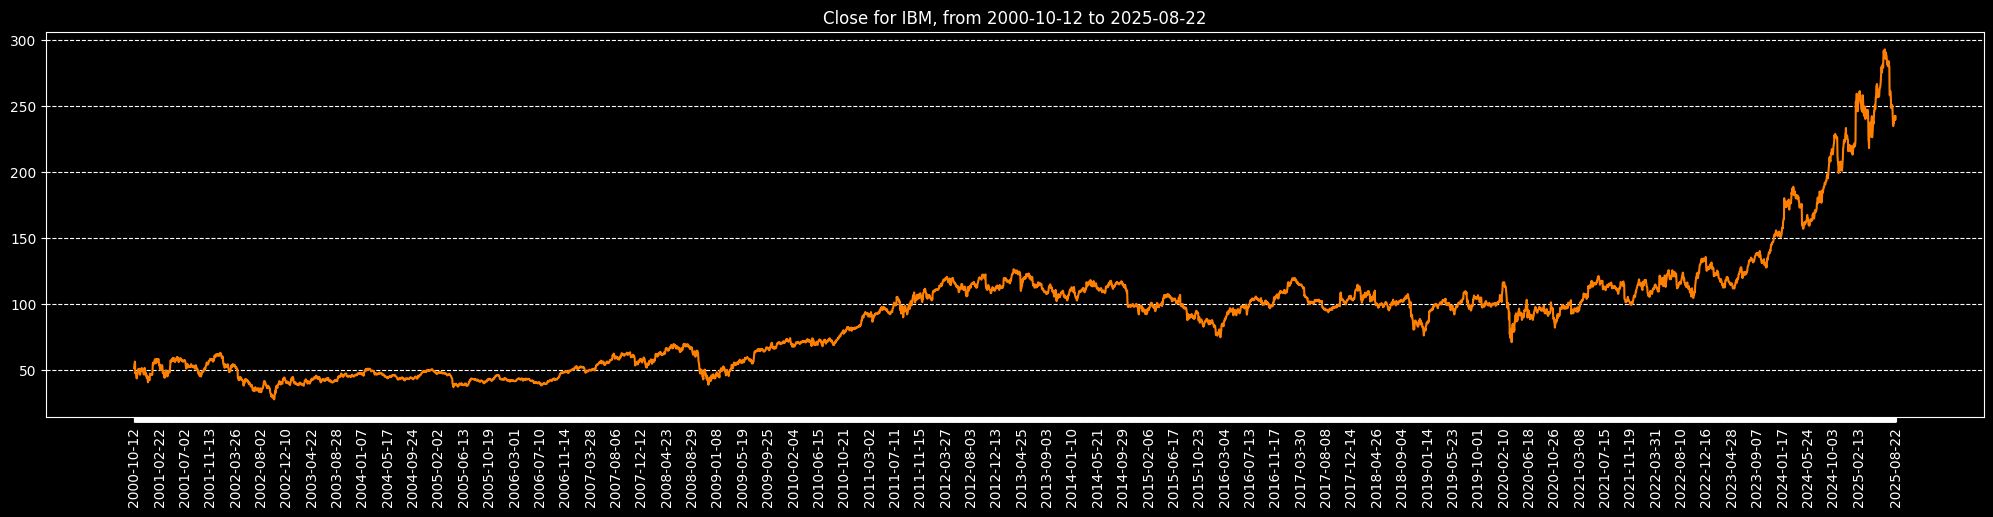

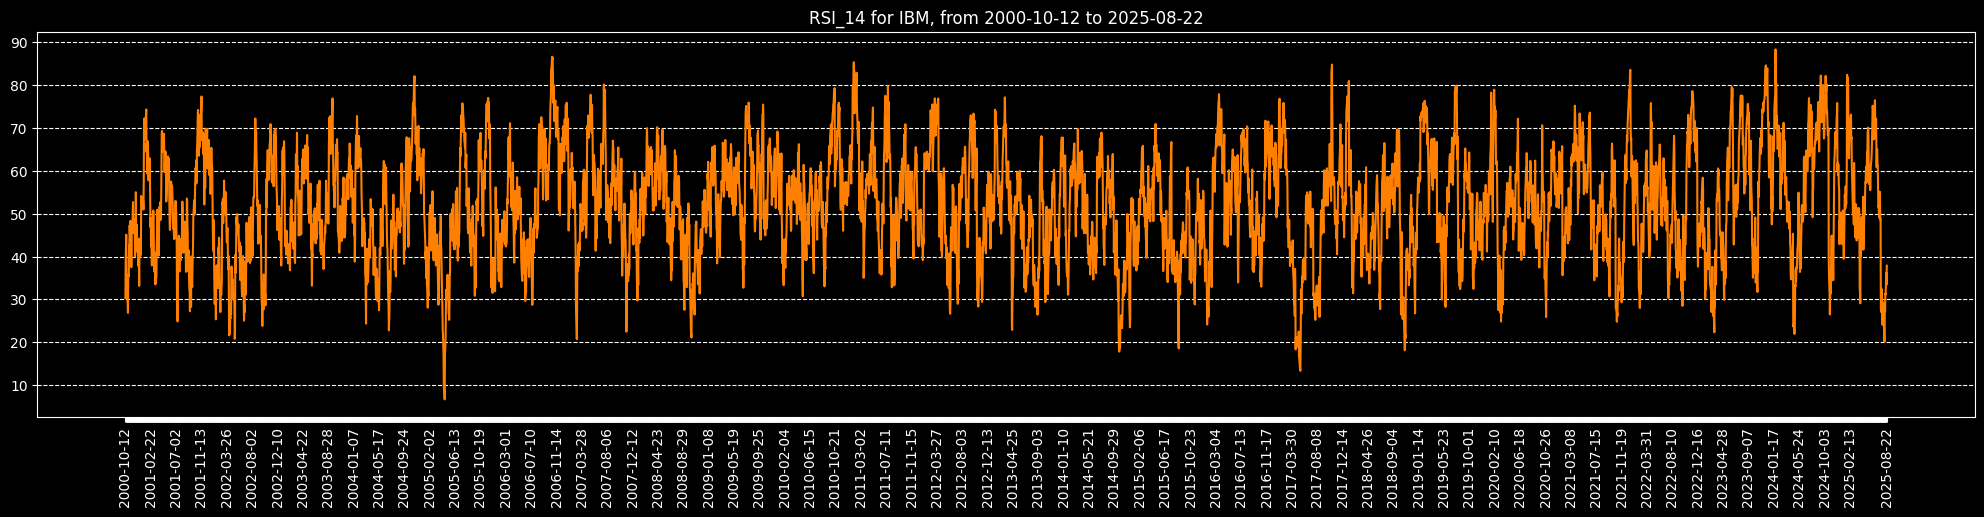

In [457]:
plt.style.use("dark_background")

def plot_feature(data_dates, df, feature, num_data_points, display_date_range):
    fig = plt.figure(figsize=(25, 5), dpi=100)
    fig.patch.set_facecolor(color="black")

    plt.plot(data_dates, df[feature].to_list(), color=config["plots"]["color_actual"])

    xticks_labels = []
    xticks_interval = config["plots"]["xticks_interval"]

    for i in range(num_data_points):
        # Always include the last data point
        if i == num_data_points - 1:
            xticks_labels.append(data_dates[i])
        # Include every xticks_interval-th point, but avoid ticks too close to the end
        elif i % xticks_interval == 0 and (num_data_points - i) > xticks_interval:
            xticks_labels.append(data_dates[i])
        else:
            xticks_labels.append(None)

    xticks_indices = np.arange(0, len(xticks_labels))
    plt.xticks(xticks_indices, xticks_labels, rotation="vertical")

    plt.title(f"{feature} for {config["yfinance"]["symbol"]}, {display_date_range}")
    plt.grid(axis="y", linestyle="--")

plot_feature(data_dates, df_features, "Close", num_data_points, display_date_range)
plot_feature(data_dates, df_features, "RSI_14", num_data_points, display_date_range)

### Normalizing raw data

In [65]:
combined_df_features = combined_df_features.copy()

for col in features_cols:
    if col.endswith("RSI_14"):
        combined_df_features[col] = (combined_df_features[col] / 100.0)
    else:
        combined_df_features[col] = (combined_df_features[col] - combined_df_features[col].mean()) / combined_df_features[col].std()

combined_df_features

,AAPL_Close,MSFT_Close,GOOG_Close,AMZN_Close,META_Close,NVDA_Close,QCOM_Close,INTC_Close,AMD_Close,TSLA_Close,...,ADBE_RSI_14,IBM_RSI_14,IBM_RSI_14,IBM_RSI_14,TXN_RSI_14,TXN_RSI_14,TXN_RSI_14,AMAT_RSI_14,AMAT_RSI_14,AMAT_RSI_14
0,-1.080803,-1.217363,-1.327665,-1.573459,-1.099648,-0.663867,-0.924188,-1.086624,-1.178462,-0.954755,...,0.520693,0.444162,0.442726,0.431349,0.386522,0.384510,0.366928,0.434596,0.432574,0.435110
1,-1.083083,-1.218786,-1.331147,-1.576810,-1.099077,-0.663771,-0.934544,-1.121526,-1.178462,-0.952988,...,0.527399,0.416922,0.415411,0.402731,0.374901,0.372885,0.354771,0.455672,0.453920,0.458439
2,-1.085811,-1.221438,-1.337861,-1.579828,-1.108403,-0.664060,-0.950401,-1.161625,-1.178839,-0.949065,...,0.481260,0.366105,0.364510,0.350152,0.321722,0.319742,0.300108,0.405080,0.403111,0.402715
3,-1.087031,-1.221955,-1.338006,-1.578096,-1.108403,-0.663998,-0.957520,-1.165338,-1.179217,-0.949224,...,0.464988,0.379545,0.378054,0.364888,0.332239,0.330339,0.311880,0.415070,0.413215,0.413678
4,-1.082344,-1.215746,-1.327676,-1.573468,-1.098950,-0.664219,-0.949916,-1.123011,-1.178651,-0.952132,...,0.565903,0.490442,0.489689,0.484806,0.449065,0.447947,0.440566,0.447544,0.446038,0.449076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2566,1.817145,2.340201,2.363717,2.100314,3.274610,3.588268,1.394238,-1.228547,2.100614,1.668879,...,0.499699,0.311739,0.311739,0.311739,0.514325,0.514325,0.514325,0.321249,0.321249,0.321249
2567,1.812410,2.285521,2.326307,2.039420,3.173254,3.439013,1.336981,-1.071123,1.919691,1.620730,...,0.527652,0.341811,0.341811,0.341811,0.537882,0.537882,0.537882,0.313431,0.313431,0.313431
2568,1.747118,2.255309,2.278506,1.965927,3.149270,3.433390,1.319480,-1.239996,1.894222,1.576202,...,0.470842,0.362625,0.362625,0.362625,0.600488,0.600488,0.600488,0.305725,0.305725,0.305725
2569,1.731190,2.250452,2.287442,1.933380,3.094286,3.423549,1.291175,-1.243812,1.866112,1.545008,...,0.470842,0.334380,0.334380,0.334380,0.599402,0.599402,0.599402,0.301531,0.301531,0.301531


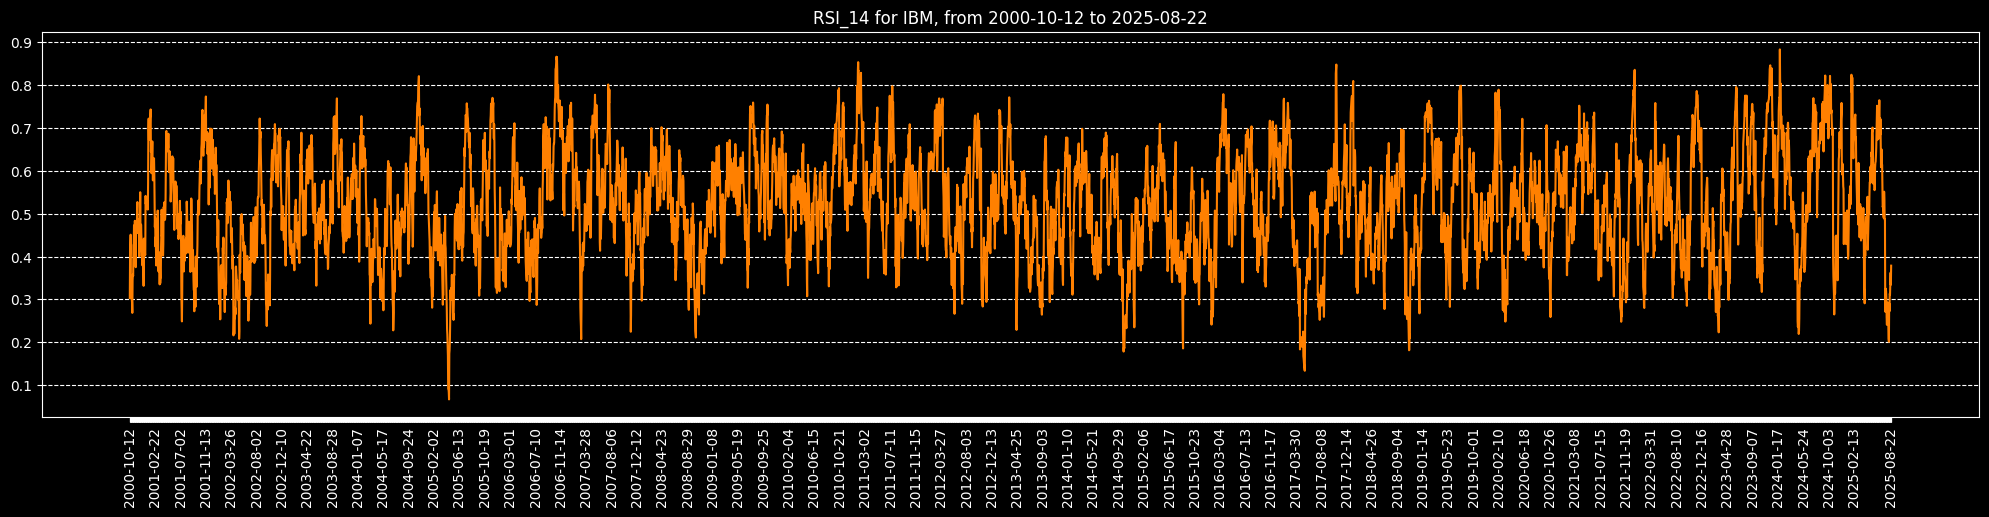

In [459]:
feature = "RSI_14"
feature_index = features.index(feature)

fig = plt.figure(figsize=(25, 5), dpi=100)
fig.patch.set_facecolor(color="black")

plt.plot(data_dates, data_scaled_features[:, feature_index], color=config["plots"]["color_actual"])

xticks_labels = []
xticks_interval = config["plots"]["xticks_interval"]

for i in range(num_data_points):
    # Always include the last data point
    if i == num_data_points - 1:
        xticks_labels.append(data_dates[i])
    # Include every xticks_interval-th point, but avoid ticks too close to the end
    elif i % xticks_interval == 0 and (num_data_points - i) > xticks_interval:
        xticks_labels.append(data_dates[i])
    else:
        xticks_labels.append(None)

xticks_indices = np.arange(0, len(xticks_labels))
plt.xticks(xticks_indices, xticks_labels, rotation="vertical")

plt.title(f"{feature} for {config["yfinance"]["symbol"]}, {display_date_range}")
plt.grid(axis="y", linestyle="--")

### Train/Val split

In [68]:
window_size = config["data"]["window_size"]

target_col = "AAPL_Close"
n_row = combined_df_features.shape[0] - window_size

X = np.array([
    combined_df_features.iloc[i:i+window_size].values 
    for i in range(n_row)
])

raw_prices = combined_df[target_col].values
log_returns = np.log(raw_prices[1:] / raw_prices[:-1])  

y = np.array([
    log_returns[i + window_size - 1] # return[t] = log(p[t+1]/p[t])
    for i in range(n_row)
])


X.shape, y.shape

((2551, 20, 323), (2551,))

In [69]:
train_end = int(config["data"]["train_split_size"] * len(y))
val_end   = int((config["data"]["train_split_size"] + config["data"]["val_split_size"]) * len(y))

X_train, y_train = X[:train_end], y[:train_end]
X_val,   y_val   = X[train_end:val_end], y[train_end:val_end]
X_test,  y_test  = X[val_end:], y[val_end:]

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(1785, 20, 323) (1785,)
(383, 20, 323) (383,)
(383, 20, 323) (383,)


### Datasets and DataLoaders

In [71]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
dataset_train = TimeSeriesDataset(X_train, y_train)
dataset_val = TimeSeriesDataset(X_val, y_val)
dataset_test = TimeSeriesDataset(X_test, y_test)

print("Train data shape:", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape:", dataset_val.x.shape, dataset_val.y.shape)
print("Test data shape:", dataset_test.x.shape, dataset_test.y.shape)


Train data shape: torch.Size([1785, 20, 323]) torch.Size([1785])
Validation data shape: torch.Size([383, 20, 323]) torch.Size([383])
Test data shape: torch.Size([383, 20, 323]) torch.Size([383])


In [72]:
train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)
test_dataloader = DataLoader(dataset_test, batch_size=config["training"]["batch_size"], shuffle=False)

## LSTM Model

$$
f_t = \sigma(W_{if} x_t + W_{hf} h_{t-1} + b_f) \\
i_t = \sigma(W_{ii} x_t + W_{hi} h_{t-1} + b_i) \\
\tilde{C}_t = \tanh(W_{iC} x_t + W_{hC} h_{t-1} + b_C) \\
o_t = \sigma(W_{io} x_t + W_{ho} h_{t-1} + b_o)
$$

In PyTorch, all the $W_{i*}$ (input -> gate) matrices are stacked together into weight_ih

All the $W_{h*}$ (hidden -> gate) are stacked together into weight_hh

$$
\begin{bmatrix}
f_t \\
i_t \\
\tilde{C}_t \\
o_t
\end{bmatrix}
=
\begin{bmatrix}
\sigma \\
\sigma \\
\tanh \\
\sigma
\end{bmatrix}
\Big(
W_{ih} x_t + W_{hh} h_{t-1} + b_{ih} + b_{hh}
\Big)
$$


In [85]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.linear_1 = nn.Linear(in_features=input_size, out_features=hidden_layer_size)
        self.relu = nn.ReLU()
        # batch_first = True makes input/output (batch_size, seq_len, feature_num) instead of (seq_len, batch_size, feature_num) 
        self.lstm = nn.LSTM(input_size=hidden_layer_size,
                            hidden_size=hidden_layer_size,
                            num_layers=num_layers, 
                            batch_first=True,
                            dropout=dropout)

        self.dropout = nn.Dropout(p=dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)

        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if "bias" in name:
                 nn.init.zeros_(param)
            elif "weight_ih" in name:
                 nn.init.kaiming_normal_(param) # normal distribution scaled to preserve variance across layers
            elif "weight_hh" in name:
                 nn.init.orthogonal_(param) # preserves the gradient norm so it doesn't vanish/explode


    def forward(self, x):

        x = self.linear_1(x) # (batch, seq_len, num_features) -> (batch, seq_len, hidden_layer_size) 
        x = self.relu(x)

        # output has shape (batch, seq_len, hidden_layer_size). Hidden state from last LSTM layer, at every time step
        # h_n has shape (num_layers, batch, hidden_layer_size). Final hidden state for each layer, at the last time step
        # c_n has the same shape as h_n. Final cell state for each layer, at the last time step.
        output, (h_n, c_n) = self.lstm(x)

        x = h_n.transpose(0, 1).reshape(x.shape[0], -1) # (num_layers, batch, hidden_layer_size) -> (batch, num_layers*hidden_layer_size)

        x = self.dropout(x)

        x = self.linear_2(x) # (batch, output_size)
        return x

## Model Training

In [ ]:
model = LSTMModel(input_size=X.shape[-1], 
                  hidden_layer_size=config["model"]["lstm_size"], 
                  num_layers=config["model"]["num_lstm_layers"], 
                  dropout=config["model"]["dropout"])

model = model.to(config["training"]["device"])

criterion = nn.MSELoss()

optimizer = optim.AdamW(params = model.parameters(),
                        lr=config["training"]["learning_rate"],
                        betas=(0.9, 0.98),
                        eps=1e-9,
                        weight_decay=config["training"]["weight_decay"])

# scheduler = optim.lr_scheduler.StepLR(optimizer,
#                                       step_size=config["training"]["scheduler_step_size"],
#                                       gamma=0.1)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode="min", 
    factor=0.5, 
    patience=10
)

device = config["training"]["device"]


best_acc = 0.0
patience_count = 0

for epoch in range(config["training"]["num_epoch"]):
    model.train()
    
    train_loss = 0.0

    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)

        train_pred = model(X)
        train_pred = train_pred.squeeze(-1)

        loss = criterion(train_pred, y)

        optimizer.zero_grad()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.detach().item()

    train_loss = train_loss / len(train_dataloader)

    model.eval()

    val_loss = 0.0
    total_weighted_correct = 0.0
    total_weights = 0.0

    with torch.inference_mode():
        for X, y in val_dataloader:
            X, y = X.to(device), y.to(device)

            val_pred = model(X)
            val_pred = val_pred.squeeze(-1)

            val_loss += criterion(val_pred, y).item()

            true_dir = torch.sign(y)
            pred_dir = torch.sign(val_pred)

            # weights = torch.abs(y)
            weights = torch.clamp(torch.abs(y), min=1e-5)

            total_weighted_correct += (true_dir == pred_dir).float().dot(weights).item()
            total_weights += weights.sum().item()


    val_loss = val_loss / len(val_dataloader)
    weighted_accuracy = total_weighted_correct / total_weights

    scheduler.step(metrics=val_loss)
    current_lr = optimizer.param_groups[0]["lr"]

    if weighted_accuracy > best_acc:
        best_acc = weighted_accuracy
        patience_count = 0
    else:
        if (patience_count >= 40):
            print(f"Early stopping triggered at epoch {epoch}!")
            break
        patience_count+=1


    print(f"Epoch {epoch:03d}/{config["training"]["num_epoch"]} | train loss: {train_loss:.6f} | val loss: {val_loss:.6f} | weighted acc: {weighted_accuracy*100:4f} | lr: {current_lr:.6f}")


Epoch 000/100 | train loss: 0.003715 | val loss: 0.000894 | weighted acc: 52.979980 | lr: 0.001000
Epoch 001/100 | train loss: 0.001027 | val loss: 0.000481 | weighted acc: 50.746786 | lr: 0.001000
Epoch 002/100 | train loss: 0.000600 | val loss: 0.000456 | weighted acc: 51.199063 | lr: 0.001000


## Model Evaluation

### Get Predictions

In [90]:
test_loss = 0.0

total_weighted_correct = 0.0
total_weights = 0.0


model.eval()
for X, y in test_dataloader:
    X, y = X.to(device), y.to(device)

    test_pred = model(X)
    test_pred = test_pred.squeeze(-1)

    test_loss += criterion(test_pred, y).item()

    true_dir = torch.sign(y)
    pred_dir = torch.sign(test_pred)

    weights = torch.abs(y)

    total_weighted_correct += (true_dir == pred_dir).float().dot(weights).item()
    total_weights += weights.sum().item()

test_loss = test_loss / len(test_dataloader)
weighted_accuracy = total_weighted_correct / total_weights

print(f"Test loss: {test_loss:.6f} | Test weighted accuracy: {weighted_accuracy*100:.2f}%")

Test loss: 0.017190 | Test weighted accuracy: 48.31%


In [ ]:


train_preds_list = []
val_preds_list = []

train_eval_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False) # no shuffle

with torch.inference_mode():
    for X, y in train_eval_dataloader:
        X, y = X.to(device), y.to(device)

        train_pred = model(X)
        train_preds_list.append(train_pred)


    for X, y in val_dataloader:
        X, y = X.to(device), y.to(device)

        val_pred = model(X)
        val_preds_list.append(val_pred)

train_preds = torch.cat(train_preds_list).cpu().detach().numpy()
val_preds = torch.cat(val_preds_list).cpu().detach().numpy()

### Plot Predictions

In [ ]:
window_size = config["data"]["window_size"]


to_plot_y_train_preds = np.array([None] * num_data_points)
to_plot_y_val_preds = np.array([None] * num_data_points)

to_plot_y_train_preds[window_size : window_size + train_end] = scaler.inverse_transform(train_preds)
to_plot_y_val_preds[window_size + train_end : window_size + val_end] = scaler.inverse_transform(val_preds)


fig = plt.figure(figsize=(25, 5), dpi=100)
fig.patch.set_facecolor(color="black")

plt.plot(data_dates, to_plot_data_y_train, label = "Train", color=config["plots"]["color_train"])
plt.plot(data_dates, to_plot_data_y_val, label = "Val", color=config["plots"]["color_val"])

plt.plot(data_dates, to_plot_y_train_preds, label = "Train preds", color=config["plots"]["color_pred_train"])
plt.plot(data_dates, to_plot_y_val_preds, label = "Val preds", color=config["plots"]["color_pred_val"])


xticks_labels = []
xticks_interval = config["plots"]["xticks_interval"]

num_pred_data_points = num_data_points - len(y_test)

for i in range(num_pred_data_points):
    if i == num_pred_data_points - 1:
        xticks_labels.append(data_dates[i])
    elif i % xticks_interval == 0 and (num_pred_data_points - i) > xticks_interval:
        xticks_labels.append(data_dates[i])
    else:
        xticks_labels.append(None)
xticks_indices = np.arange(0, len(xticks_labels))

plt.xticks(xticks_indices, xticks_labels, rotation="vertical")
plt.title(f"Daily close price for {config["alpha_vantage"]["symbol"]}, {display_date_range} - Predicted Prices")
plt.grid(axis="y", linestyle="--")
plt.legend(fontsize=14)


ValueError: non-broadcastable output operand with shape (4361,1) doesn't match the broadcast shape (4361,6)

### Zoom in on Val Preds

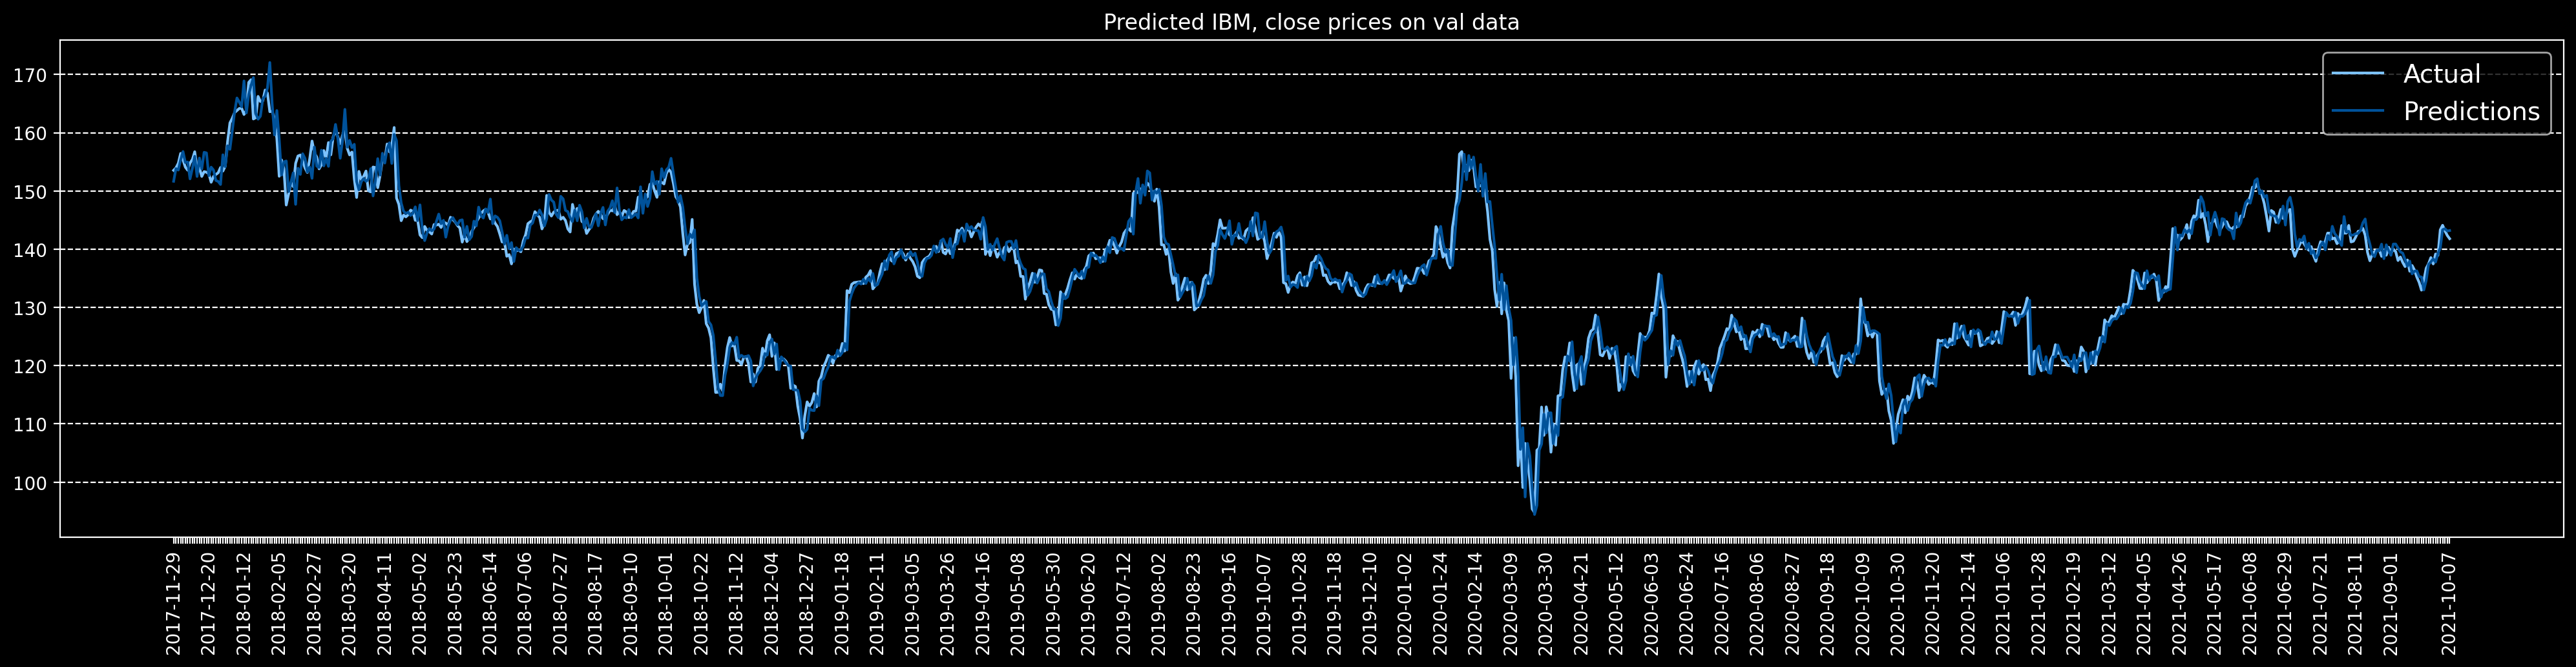

In [ ]:
y_val_preds = scaler.inverse_transform(val_preds)
y_val_only = scaler.inverse_transform(y_val)

data_dates_val = data_dates[window_size + train_end : window_size + val_end]

fig = plt.figure(figsize=(25, 5), dpi=200)
fig.patch.set_facecolor(color="black")

plt.plot(data_dates_val, y_val_only, label = "Actual", color=config["plots"]["color_val"])
plt.plot(data_dates_val, y_val_preds, label = "Predictions", color=config["plots"]["color_pred_val"])


xticks_labels = []
xticks_interval = config["plots"]["xticks_interval"] // 6

num_val_data_points = len(data_dates_val)

for i in range(num_val_data_points):
    if i == num_val_data_points - 1:
        xticks_labels.append(data_dates_val[i])
    elif i % (xticks_interval) == 0 and (num_val_data_points - i) > (xticks_interval):
        xticks_labels.append(data_dates_val[i])
    else:
        xticks_labels.append(None)
xticks_indices = np.arange(0, len(xticks_labels))

plt.xticks(xticks_indices, xticks_labels, rotation="vertical")
plt.title(f"Predicted {config["alpha_vantage"]["symbol"]}, close prices on val data")
plt.grid(axis="y", linestyle="--")
plt.legend(fontsize=14)


### Predictions on Test Data

In [498]:
y_true = torch.tensor(y_test)
y_pred = torch.tensor(test_preds)

true_dir = torch.sign(y_true[1:] - y_true[:-1])
pred_dir = torch.sign(y_pred[1:] - y_true[:-1])

weights = torch.abs(y_true[1:] - y_true[:-1]) / y_true[:-1]

weighted_correct = (true_dir == pred_dir).float() * weights
weighted_accuracy = weighted_correct.sum() / weights.sum()

print(f"Weighted Directional Accuracy: {100*weighted_accuracy:.2f}%")

Weighted Directional Accuracy: 43.19%


In [483]:
y_test_only = scaler.inverse_transform(y_test)
y_test_preds = scaler.inverse_transform(test_preds)

data_dates_test = data_dates[window_size + val_end:]


fig = plt.figure(figsize=(25, 5), dpi=200)
fig.patch.set_facecolor(color="black")

plt.plot(data_dates_test, y_test_only, label = "Actual", color=config["plots"]["color_test"])
plt.plot(data_dates_test, y_test_preds, label = "Prediction", color=config["plots"]["color_pred_test"])

xticks_labels = []
xticks_interval = config["plots"]["xticks_interval"] // 6

num_test_data_points = len(data_dates_test)

for i in range(num_test_data_points):
    if i == num_test_data_points - 1:
        xticks_labels.append(data_dates_test[i])
    elif i % (xticks_interval) == 0 and (num_test_data_points - i) > (xticks_interval):
        xticks_labels.append(data_dates_test[i])
    else:
        xticks_labels.append(None)
xticks_indices = np.arange(0, len(xticks_labels))

plt.xticks(xticks_indices, xticks_labels, rotation="vertical")
plt.title(f"Predicted {config["alpha_vantage"]["symbol"]}, close prices on test data")
plt.grid(axis="y", linestyle="--")
plt.legend(fontsize=14)

ValueError: non-broadcastable output operand with shape (935,1) doesn't match the broadcast shape (935,6)

#### Zoom in

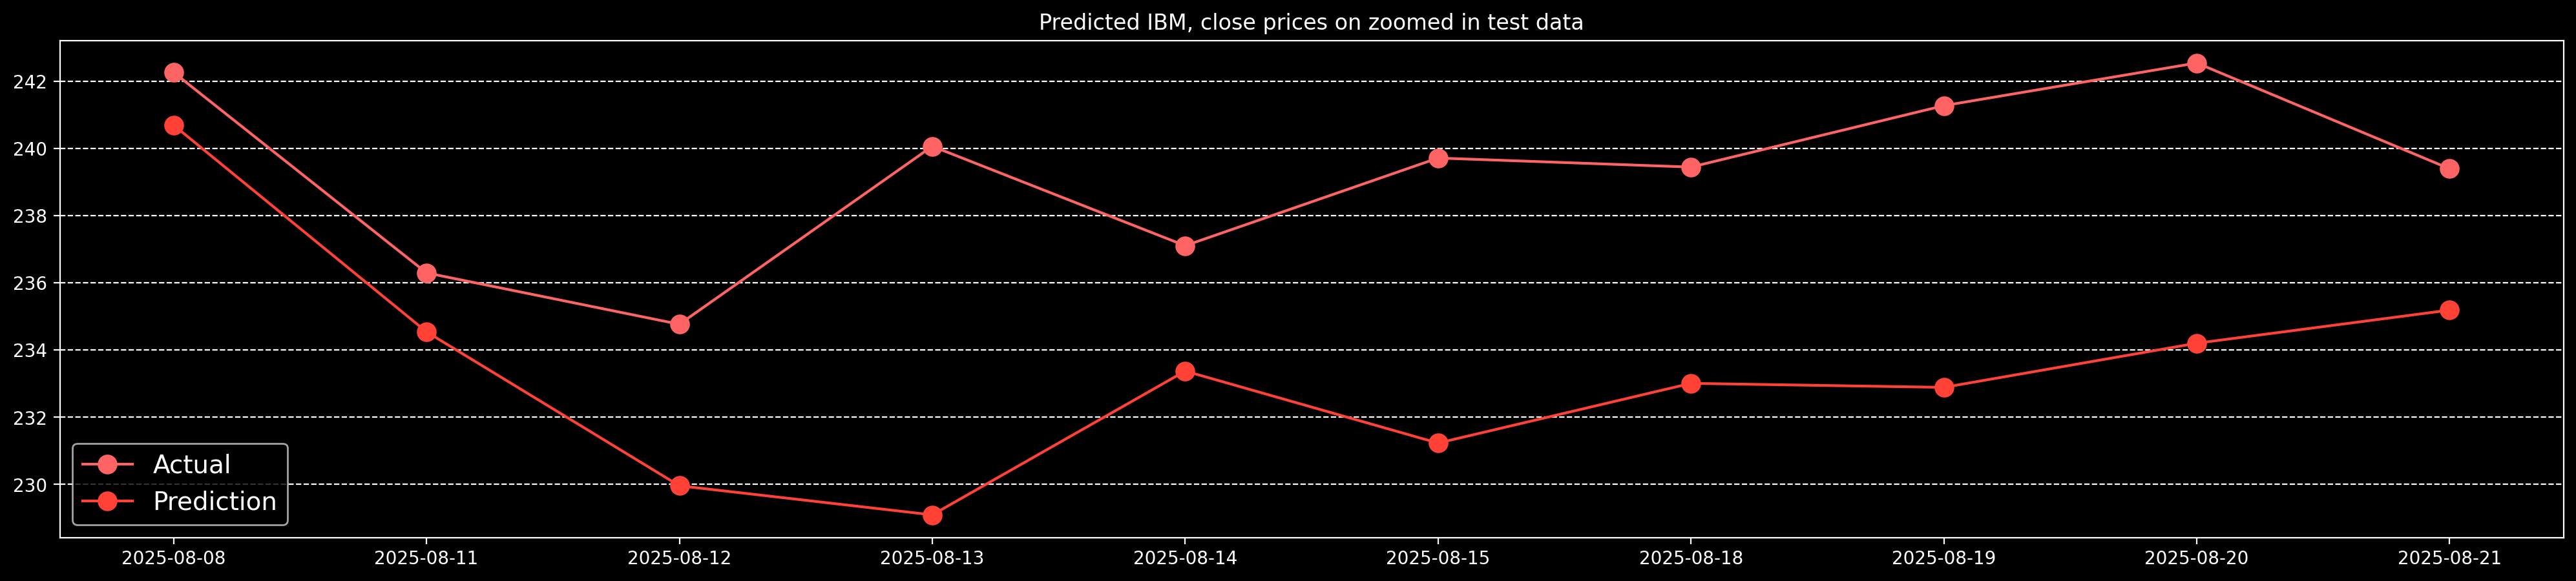

In [ ]:
y_test_zoomed = y_test_only[-10:]
y_test_preds_zoomed = y_test_preds[-10:]

data_dates_test_zoomed = data_dates[-10:]


fig = plt.figure(figsize=(25, 5), dpi=200)
fig.patch.set_facecolor(color="black")

plt.plot(data_dates_test_zoomed, y_test_zoomed, label = "Actual", color=config["plots"]["color_test"], marker="o", markersize=10)
plt.plot(data_dates_test_zoomed, y_test_preds_zoomed, label = "Prediction", color=config["plots"]["color_pred_test"], marker="o", markersize=10)


plt.title(f"Predicted {config["alpha_vantage"]["symbol"]}, close prices on zoomed in test data")
plt.grid(axis="y", linestyle="--")
plt.legend(fontsize=14)